In [ ]:
# 2. Mount Google Drive dan Ekstrak Dataset (jika perlu)
from google.colab import drive
drive.mount('/content/drive')

# 1. Import Library
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder, StandardScaler

!pip install rarfile

# 2. Mount Google Drive dan Ekstrak Dataset (jika perlu)
from google.colab import drive
drive.mount('/content/drive')

# Contoh ekstraksi file RAR (jika dataset dikemas)
import rarfile
rar_path = '/content/drive/MyDrive/Colab Notebooks/dataset/Image Classification/Potholes Image 4 Class.rar'
extract_path = '/content/sample_data/jalan'
os.makedirs(extract_path, exist_ok=True)
with rarfile.RarFile(rar_path, 'r') as rar_ref:
    rar_ref.extractall(extract_path)

# 3. Set Paths untuk CSV dan Gambar
train_csv_path = "/content/drive/MyDrive/Colab Notebooks/dataset/Image Classification/Road Damage Classification/bbox_label_train.csv"
val_csv_path   = "/content/drive/MyDrive/Colab Notebooks/dataset/Image Classification/Road Damage Classification/bbox_label_val.csv"
test_csv_path  = "/content/drive/MyDrive/Colab Notebooks/dataset/Image Classification/Road Damage Classification/bbox_label_test.csv"

train_img_dir = "/content/sample_data/jalan/pavementscapes/img/train"
val_img_dir   = "/content/sample_data/jalan/pavementscapes/img/val"
test_img_dir  = "/content/sample_data/jalan/pavementscapes/img/test"

# 4. Baca CSV
cols = ["image_id", "xmin", "ymin", "xmax", "ymax",
        "jeniskerusakanjalan", "ukuran", "estimasiwaktuperbaikan",
        "jenisbahanuntukperbaikan", "jumlahbahanyangdiperlukan", "satuan"]

train_df = pd.read_csv(train_csv_path, sep=",", header=None, names=cols)
val_df   = pd.read_csv(val_csv_path, sep=",", header=None, names=cols)
test_df  = pd.read_csv(test_csv_path, sep=",", header=None, names=cols)

# Tampilkan beberapa baris data
print("Train Data Head:")
print(train_df.head())
print("\nValidation Data Head:")
print(val_df.head())
print("\nTest Data Head:")
print(test_df.head())

# 5. Encode Label untuk Kerusakan dan Bahan
damage_le = LabelEncoder()
train_df["damage_label"] = damage_le.fit_transform(train_df["jeniskerusakanjalan"])
val_df["damage_label"]   = damage_le.transform(val_df["jeniskerusakanjalan"])
test_df["damage_label"]  = damage_le.transform(test_df["jeniskerusakanjalan"])

material_le = LabelEncoder()
train_df["material_label"] = material_le.fit_transform(train_df["jenisbahanuntukperbaikan"])
val_df["material_label"]   = material_le.transform(val_df["jenisbahanuntukperbaikan"])
test_df["material_label"]  = material_le.transform(test_df["jenisbahanuntukperbaikan"])

# 6. Print Statistik dan Distribusi Target (Kebutuhan nomor 1-4)
print("\nDistribusi Jenis Kerusakan (Train):")
print(train_df["jeniskerusakanjalan"].value_counts())
print("\nDistribusi Bahan Perbaikan (Train):")
print(train_df["jenisbahanuntukperbaikan"].value_counts())
print("\nStatistik Ukuran (Train):")
# Karena kolom 'ukuran' memiliki format yang berbeda, kita tampilkan beberapa contoh
print(train_df["ukuran"].head(10))
print("\nStatistik Estimasi Waktu Perbaikan (Train):")
print(train_df["estimasiwaktuperbaikan"].describe())
print("\nStatistik Jumlah Bahan yang Diperlukan (Train):")
print(train_df["jumlahbahanyangdiperlukan"].describe())

# Pertama, buat kolom 'ukuran_1' dan 'ukuran_2' dari kolom 'ukuran'
train_df[['ukuran_1', 'ukuran_2']] = train_df['ukuran'].apply(
    lambda x: pd.Series([float(y) if y else 0.0 for y in str(x).replace(" ", "").split(",")[:2]])
)
val_df[['ukuran_1', 'ukuran_2']] = val_df['ukuran'].apply(
    lambda x: pd.Series([float(y) if y else 0.0 for y in str(x).replace(" ", "").split(",")[:2]])
)
test_df[['ukuran_1', 'ukuran_2']] = test_df['ukuran'].apply(
    lambda x: pd.Series([float(y) if y else 0.0 for y in str(x).replace(" ", "").split(",")[:2]])
)

# Bersihkan dan konversi kolom 'estimasiwaktuperbaikan'
train_df['estimasiwaktuperbaikan'] = pd.to_numeric(
    train_df['estimasiwaktuperbaikan'].astype(str).str.replace(' ', '').str.replace(',', '.'),
    errors='coerce'
)
val_df['estimasiwaktuperbaikan'] = pd.to_numeric(
    val_df['estimasiwaktuperbaikan'].astype(str).str.replace(' ', '').str.replace(',', '.'),
    errors='coerce'
)
test_df['estimasiwaktuperbaikan'] = pd.to_numeric(
    test_df['estimasiwaktuperbaikan'].astype(str).str.replace(' ', '').str.replace(',', '.'),
    errors='coerce'
)

# Bersihkan dan konversi kolom 'jumlahbahanyangdiperlukan'
train_df['jumlahbahanyangdiperlukan'] = pd.to_numeric(
    train_df['jumlahbahanyangdiperlukan'].astype(str).str.replace(' ', '').str.replace(',', '.'),
    errors='coerce'
)
val_df['jumlahbahanyangdiperlukan'] = pd.to_numeric(
    val_df['jumlahbahanyangdiperlukan'].astype(str).str.replace(' ', '').str.replace(',', '.'),
    errors='coerce'
)
test_df['jumlahbahanyangdiperlukan'] = pd.to_numeric(
    test_df['jumlahbahanyangdiperlukan'].astype(str).str.replace(' ', '').str.replace(',', '.'),
    errors='coerce'
)

# Cek apakah ada nilai NaN (jika ada, Anda bisa menghapus atau menggantinya)
print("NaN in estimasiwaktuperbaikan:", train_df['estimasiwaktuperbaikan'].isna().sum())
print("NaN in jumlahbahanyangdiperlukan:", train_df['jumlahbahanyangdiperlukan'].isna().sum())

# Sekarang lakukan normalisasi menggunakan StandardScaler
from sklearn.preprocessing import StandardScaler

size_scaler = StandardScaler().fit(train_df[['ukuran_1', 'ukuran_2']].values)
time_scaler = StandardScaler().fit(train_df['estimasiwaktuperbaikan'].values.reshape(-1, 1))
quantity_scaler = StandardScaler().fit(train_df['jumlahbahanyangdiperlukan'].values.reshape(-1, 1))

train_df[['ukuran_1', 'ukuran_2']] = size_scaler.transform(train_df[['ukuran_1', 'ukuran_2']].values)
val_df[['ukuran_1', 'ukuran_2']] = size_scaler.transform(val_df[['ukuran_1', 'ukuran_2']].values)
test_df[['ukuran_1', 'ukuran_2']] = size_scaler.transform(test_df[['ukuran_1', 'ukuran_2']].values)

train_df['estimasiwaktuperbaikan'] = time_scaler.transform(train_df['estimasiwaktuperbaikan'].values.reshape(-1, 1))
val_df['estimasiwaktuperbaikan'] = time_scaler.transform(val_df['estimasiwaktuperbaikan'].values.reshape(-1, 1))
test_df['estimasiwaktuperbaikan'] = time_scaler.transform(test_df['estimasiwaktuperbaikan'].values.reshape(-1, 1))

train_df['jumlahbahanyangdiperlukan'] = quantity_scaler.transform(train_df['jumlahbahanyangdiperlukan'].values.reshape(-1, 1))
val_df['jumlahbahanyangdiperlukan'] = quantity_scaler.transform(val_df['jumlahbahanyangdiperlukan'].values.reshape(-1, 1))
test_df['jumlahbahanyangdiperlukan'] = quantity_scaler.transform(test_df['jumlahbahanyangdiperlukan'].values.reshape(-1, 1))


train_transform = A.Compose([
    A.RandomResizedCrop(
        size=(224, 224),
        scale=(0.8, 1.0),
        ratio=(0.75, 1.33),
        interpolation=cv2.INTER_LINEAR,
        mask_interpolation=cv2.INTER_NEAREST,
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.RandomResizedCrop(
        size=(224, 224),
        scale=(0.8, 1.0),
        ratio=(0.75, 1.33),
        interpolation=cv2.INTER_LINEAR,
        mask_interpolation=cv2.INTER_NEAREST,
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

class RoadDamageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None,
                 size_scaler=None, time_scaler=None, quantity_scaler=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

        # Normalizers
        self.size_scaler = size_scaler
        self.time_scaler = time_scaler
        self.quantity_scaler = quantity_scaler

        # Preprocess targets
        self._preprocess_targets()

    def _preprocess_targets(self):
        # Parse ukuran
        self.df[['ukuran_1', 'ukuran_2']] = self.df['ukuran'].apply(
            lambda x: pd.Series(self._parse_size(x)))

        # Normalisasi
        if self.size_scaler:
            size_features = self.df[['ukuran_1', 'ukuran_2']].values
            self.df[['ukuran_1', 'ukuran_2']] = self.size_scaler.transform(size_features)

        if self.time_scaler:
            self.df['estimasiwaktuperbaikan'] = self.time_scaler.transform(
                self.df['estimasiwaktuperbaikan'].values.reshape(-1, 1))

        if self.quantity_scaler:
            self.df['jumlahbahanyangdiperlukan'] = self.quantity_scaler.transform(
                self.df['jumlahbahanyangdiperlukan'].values.reshape(-1, 1))

    def _parse_size(self, size_str):
        try:
            parts = str(size_str).replace(" ", "").split(",")
            if len(parts) == 1:
                return [float(parts[0]), 0.0]
            return list(map(float, parts))
        except:
            return [0.0, 0.0]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, str(row["image_id"]) + ".jpg")
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ROI Cropping
        x1, y1, x2, y2 = row[['xmin','ymin','xmax','ymax']].astype(int)
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)
        roi = image[y1:y2, x1:x2]

        if roi.size == 0:
            roi = image  # Fallback ke full image jika ROI invalid

        if self.transform:
            augmented = self.transform(image=roi)
            image = augmented['image']
        else:
            image = torch.tensor(roi).permute(2,0,1).float()/255.0

        # Target processing
        damage = int(row["damage_label"])
        material = int(row["material_label"])

        size = torch.tensor([row['ukuran_1'], row['ukuran_2']], dtype=torch.float)
        repair_time = torch.tensor(row['estimasiwaktuperbaikan'], dtype=torch.float)
        quantity = torch.tensor(row['jumlahbahanyangdiperlukan'], dtype=torch.float)

        return {
            "image": image,
            "damage": damage,
            "material": material,
            "size": size,
            "repair_time": repair_time,
            "quantity": quantity
        }

# 9. Buat Dataset dan DataLoader
train_dataset = RoadDamageDataset(train_df, train_img_dir, transform=train_transform)
val_dataset   = RoadDamageDataset(val_df, val_img_dir, transform=val_transform)
test_dataset  = RoadDamageDataset(test_df, test_img_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# 10. Definisikan Model Multi-Tugas dengan Swin Transformer
class MultiTaskSwin(nn.Module):
    def __init__(self, num_damage_classes, num_material_classes):
        super().__init__()
        self.backbone = timm.create_model("swin_small_patch4_window7_224", pretrained=True, num_classes=0)
        feat_dim = self.backbone.num_features

        # Task-specific heads dengan layer deeper
        self.damage_head = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_damage_classes)
        )

        self.material_head = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_material_classes)
        )

        # Regression heads
        self.size_head = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.GELU(),
            nn.Linear(256, 2)
        )

        self.time_head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.GELU(),
            nn.Linear(128, 1)
        )

        self.quantity_head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.ReLU()
        )

    def forward(self, x):
        features = self.backbone(x)
        return {
            "damage": self.damage_head(features),
            "material": self.material_head(features),
            "size": self.size_head(features),
            "time": self.time_head(features),
            "quantity": self.quantity_head(features)
        }

# 11. Loss Functions dan Optimizer
class MultiTaskLoss(nn.Module):
    def __init__(self, damage_weights=None):
        super().__init__()
        self.damage_loss = nn.CrossEntropyLoss(weight=damage_weights)
        self.material_loss = nn.CrossEntropyLoss()
        self.size_loss = nn.HuberLoss()
        self.time_loss = nn.HuberLoss()
        self.quantity_loss = nn.HuberLoss()

        # Task weights
        self.w_damage = 1.0
        self.w_material = 1.0
        self.w_size = 1.0
        self.w_time = 0.7
        self.w_quantity = 2.0

    def forward(self, outputs, targets):
        loss_damage = self.damage_loss(outputs['damage'], targets['damage'])
        loss_material = self.material_loss(outputs['material'], targets['material'])
        loss_size = self.size_loss(outputs['size'], targets['size'])
        loss_time = self.time_loss(outputs['time'].squeeze(), targets['repair_time'])
        loss_quantity = self.quantity_loss(outputs['quantity'].squeeze(), targets['quantity'])

        total_loss = (self.w_damage * loss_damage +
                     self.w_material * loss_material +
                     self.w_size * loss_size +
                     self.w_time * loss_time +
                     self.w_quantity * loss_quantity)

        return total_loss

# 12. Inisialisasi Model, Optimizer, dan Scheduler
num_damage_classes = len(damage_le.classes_)
num_material_classes = len(material_le.classes_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskSwin(num_damage_classes, num_material_classes).to(device)
model.to(device)

# Hitung class weights untuk damage
class_counts = train_df['damage_label'].value_counts().sort_index().values
damage_weights = 1.0 / class_counts
damage_weights = torch.tensor(damage_weights, dtype=torch.float32).to(device)

optimizer = optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': 1e-5},
    {'params': model.damage_head.parameters(), 'lr': 1e-4},
    {'params': model.material_head.parameters(), 'lr': 2e-4},
    {'params': model.size_head.parameters(), 'lr': 2e-4},
    {'params': model.time_head.parameters(), 'lr': 1e-4},
    {'params': model.quantity_head.parameters(), 'lr': 2e-4}
])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

loss_fn = MultiTaskLoss(damage_weights=damage_weights)

# 13. Training Loop
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        targets = {
            "damage": batch["damage"].to(device),
            "material": batch["material"].to(device),
            "size": batch["size"].to(device),
            "repair_time": batch["repair_time"].to(device),
            "quantity": batch["quantity"].to(device)
        }
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs["damage"], dim=1)
        train_correct += (preds == targets["damage"]).sum().item()
        train_total += images.size(0)
    train_loss /= len(train_dataset)
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            targets = {
                "damage": batch["damage"].to(device),
                "material": batch["material"].to(device),
                "size": batch["size"].to(device),
                "repair_time": batch["repair_time"].to(device),
                "quantity": batch["quantity"].to(device)
            }
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs["damage"], dim=1)
            val_correct += (preds == targets["damage"]).sum().item()
            val_total += images.size(0)
    val_loss /= len(val_dataset)
    val_acc = val_correct / val_total

    # Adjust learning rate
    scheduler.step(val_loss)

    # Simpan model terbaik
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/best_model1.pth")

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error, classification_report

def evaluate_model(model, data_loader, device):
    model.eval()

    all_damage_preds = []
    all_damage_labels = []

    all_material_preds = []
    all_material_labels = []

    all_size_preds = []  # shape (n, size_dim)
    all_size_labels = []

    all_time_preds = []
    all_time_labels = []

    all_quantity_preds = []
    all_quantity_labels = []

    with torch.no_grad():
        for batch in data_loader:
            images = batch["image"].to(device)
            targets = {
                "damage": batch["damage"].to(device),
                "size": batch["size"].to(device),
                "repair_time": batch["repair_time"].to(device),
                "material": batch["material"].to(device),
                "quantity": batch["quantity"].to(device)
            }

            outputs = model(images)

            # Klasifikasi damage: gunakan key "damage"
            _, damage_preds = torch.max(outputs["damage"], dim=1)
            all_damage_preds.extend(damage_preds.cpu().numpy())
            all_damage_labels.extend(targets["damage"].cpu().numpy())

            # Klasifikasi material
            _, material_preds = torch.max(outputs["material"], dim=1)
            all_material_preds.extend(material_preds.cpu().numpy())
            all_material_labels.extend(targets["material"].cpu().numpy())

            # Regresi ukuran (size)
            all_size_preds.append(outputs["size"].cpu().numpy())
            all_size_labels.append(targets["size"].cpu().numpy())

            # Regresi waktu perbaikan
            all_time_preds.extend(outputs["time"].squeeze().cpu().numpy())
            all_time_labels.extend(targets["repair_time"].cpu().numpy())

            # Regresi jumlah bahan
            all_quantity_preds.extend(outputs["quantity"].squeeze().cpu().numpy())
            all_quantity_labels.extend(targets["quantity"].cpu().numpy())

    all_size_preds = np.concatenate(all_size_preds, axis=0)
    all_size_labels = np.concatenate(all_size_labels, axis=0)

    # Klasifikasi damage
    damage_acc = accuracy_score(all_damage_labels, all_damage_preds)
    damage_cm = confusion_matrix(all_damage_labels, all_damage_preds)
    damage_cr = classification_report(all_damage_labels, all_damage_preds, target_names=damage_le.classes_)

    # Klasifikasi material
    material_acc = accuracy_score(all_material_labels, all_material_preds)
    material_cm = confusion_matrix(all_material_labels, all_material_preds)
    material_cr = classification_report(all_material_labels, all_material_preds, target_names=material_le.classes_)

    # Regresi ukuran
    size_mse = mean_squared_error(all_size_labels, all_size_preds)
    size_mae = mean_absolute_error(all_size_labels, all_size_preds)

    # Regresi waktu perbaikan
    time_mse = mean_squared_error(all_time_labels, all_time_preds)
    time_mae = mean_absolute_error(all_time_labels, all_time_preds)

    # Regresi jumlah bahan
    quantity_mse = mean_squared_error(all_quantity_labels, all_quantity_preds)
    quantity_mae = mean_absolute_error(all_quantity_labels, all_quantity_preds)

    metrics_dict = {
        "damage_acc": damage_acc,
        "damage_cm": damage_cm,
        "damage_cr": damage_cr,
        "material_acc": material_acc,
        "material_cm": material_cm,
        "material_cr": material_cr,
        "size_mse": size_mse,
        "size_mae": size_mae,
        "time_mse": time_mse,
        "time_mae": time_mae,
        "quantity_mse": quantity_mse,
        "quantity_mae": quantity_mae,
    }
    return metrics_dict

# Evaluasi pada test set
metrics_results = evaluate_model(model, test_loader, device)
print("Evaluation Metrics:")
print("Damage Classification Accuracy:", metrics_results["damage_acc"])
print("Damage Classification Report:\n", metrics_results["damage_cr"])

# Plot Damage Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(metrics_results["damage_cm"], annot=True, fmt='d', cmap='Blues',
            xticklabels=damage_le.classes_, yticklabels=damage_le.classes_)
plt.title("Damage Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Material Classification Accuracy:", metrics_results["material_acc"])
print("Material Classification Report:\n", metrics_results["material_cr"])

# Plot Material Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(metrics_results["material_cm"], annot=True, fmt='d', cmap='Greens',
            xticklabels=material_le.classes_, yticklabels=material_le.classes_)
plt.title("Material Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Size Regression - MSE:", metrics_results["size_mse"], "MAE:", metrics_results["size_mae"])
print("Repair Time Regression - MSE:", metrics_results["time_mse"], "MAE:", metrics_results["time_mae"])
print("Quantity Regression - MSE:", metrics_results["quantity_mse"], "MAE:", metrics_results["quantity_mae"])

torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/model/road_classification_model1.pth")
print("Final model saved.")

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train Data Head:
            image_id  xmin  ymin  xmax  ymax jeniskerusakanjalan     ukuran  \
0  00000434-00000022  1136   139  1165   188        lubang jalan        3.9   
1  00000434-00000022     8   670   743   773     retakan lateral  73.5,10.3   
2  00000510-00000026  1654     7  1750   249   retakan memanjang   24.2,9.6   
3  00000510-00000026  1582   249  1630   359   retakan memanjang     11,4.8   
4  00000510-00000026  1585   378  1611   459   retakan memanjang    8.1,2.6   

  estimasiwaktuperbaikan jenisbahanuntukperbaikan  jumlahbahanyangdiperlukan  \
0                     10     Aspal Panas Campuran                       0.14   
1                     15         Penambal Retakan                       0.76   
2                      5         Penambal Retakan                       0.23   
3                      2         

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

<ipython-input-2-96c5d0fd5c2e>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Saving Jenis-Kerusakan-Jalan-Aspal.jpg to Jenis-Kerusakan-Jalan-Aspal.jpg
Uploaded file: Jenis-Kerusakan-Jalan-Aspal.jpg


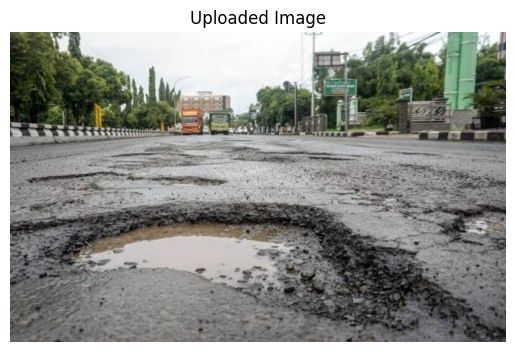

Predicted Damage: ['lubang jalan']
Predicted Material: ['Aspal Panas Campuran']
Predicted Size (as is): [[44.272312    0.49141282]]
Predicted Repair Time: 56.35084496835899 Menit
Predicted Quantity Material: 24.717026675866265 Kg
Range quantity yang dinormalisasi:
-0.5669862866762689
9.492941747514061


In [ ]:
import torch
from google.colab import files
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt

# Pastikan model dan arsitektur sudah didefinisikan (contoh definisi ulang)
class MultiTaskSwin(nn.Module):
    def __init__(self, num_damage_classes, num_material_classes):
        super(MultiTaskSwin, self).__init__()
        self.backbone = timm.create_model("swin_small_patch4_window7_224", pretrained=True, num_classes=0)
        feat_dim = self.backbone.num_features

        self.damage_head = torch.nn.Sequential(
            torch.nn.Linear(feat_dim, 512),
            torch.nn.GELU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, num_damage_classes)
        )

        self.material_head = torch.nn.Sequential(
            torch.nn.Linear(feat_dim, 256),
            torch.nn.GELU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, num_material_classes)
        )

        self.size_head = torch.nn.Sequential(
            torch.nn.Linear(feat_dim, 256),
            torch.nn.GELU(),
            torch.nn.Linear(256, 2)
        )

        self.time_head = torch.nn.Sequential(
            torch.nn.Linear(feat_dim, 128),
            torch.nn.GELU(),
            torch.nn.Linear(128, 1)
        )

        self.quantity_head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.ReLU()
        )

    def forward(self, x):
        features = self.backbone(x)
        return {
            "damage": self.damage_head(features),
            "material": self.material_head(features),
            "size": self.size_head(features),
            "time": self.time_head(features),
            "quantity": self.quantity_head(features)
        }

# Pastikan label encoder sudah didefinisikan dari training
# damage_le = ... ; material_le = ...

# Misalnya, inisialisasi model dengan jumlah kelas yang sesuai:
num_damage_classes = len(damage_le.classes_)
num_material_classes = len(material_le.classes_)
model = MultiTaskSwin(num_damage_classes, num_material_classes)

# Tentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load model dari file (ubah path sesuai lokasi file model Anda)
model_path = "/content/drive/MyDrive/Colab Notebooks/best_model1.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Upload gambar untuk inferensi
uploaded = files.upload()
filename = next(iter(uploaded))
print(f"Uploaded file: {filename}")

# Baca gambar dengan PIL dan konversi ke RGB
image_pil = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')
plt.imshow(image_pil)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# Konversi gambar ke numpy array
image_np = np.array(image_pil)

# Terapkan transformasi validasi (pastikan val_transform sudah didefinisikan)
transformed = val_transform(image=image_np)['image']

# Tambahkan dimensi batch dan kirim ke device
input_tensor = transformed.unsqueeze(0).to(device)

# Lakukan inferensi
with torch.no_grad():
    outputs = model(input_tensor)

# Proses prediksi:
# Klasifikasi damage
_, damage_pred = torch.max(outputs["damage"], dim=1)
# Klasifikasi material
_, material_pred = torch.max(outputs["material"], dim=1)
# Regresi ukuran (size) – tidak dinormalisasi (output asli)
size_pred = outputs["size"].cpu().numpy()   # berbentuk [batch_size, 2]
# Regresi waktu perbaikan dan quantity (target dinormalisasi selama training)
time_pred_norm = outputs["time"].squeeze().cpu().item()
quantity_pred_norm = outputs["quantity"].squeeze().cpu().item()

# Lakukan inverse transform untuk mendapatkan nilai asli repair time dan quantity
repair_time_original = time_scaler.inverse_transform(np.array([[time_pred_norm]]))[0][0]
quantity_original = quantity_scaler.inverse_transform(np.array([[quantity_pred_norm]]))[0][0]

# Konversi label numerik ke label asli
damage_label = damage_le.inverse_transform(damage_pred.cpu().numpy())
material_label = material_le.inverse_transform(material_pred.cpu().numpy())

print("Predicted Damage:", damage_label)
print("Predicted Material:", material_label)
print("Predicted Size (as is):", size_pred)  # Contoh: [[diameter, 0.0]] atau [panjang, lebar]
print("Predicted Repair Time:", repair_time_original, "Menit")
print("Predicted Quantity Material:", quantity_original, "Kg")
# Sebelum training, cek range nilai quantity yang dinormalisasi
print("Range quantity yang dinormalisasi:")
print(train_df['jumlahbahanyangdiperlukan'].min())
print(train_df['jumlahbahanyangdiperlukan'].max())

In [ ]:
import pickle
import joblib

# Simpan label encoder untuk damage dan material ke file .pkl
with open('/content/sample_data/damage_le.pkl', 'wb') as f:
    pickle.dump(damage_le, f)
with open('/content/sample_data/material_le.pkl', 'wb') as f:
    pickle.dump(material_le, f)

# Simpan scaler untuk waktu perbaikan dan quantity ke file .pkl menggunakan joblib
joblib.dump(time_scaler, '/content/sample_data/time_scaler.pkl')
joblib.dump(quantity_scaler, '/content/sample_data/quantity_scaler.pkl')

print("Label encoders dan scalers berhasil disimpan!")

Label encoders dan scalers berhasil disimpan!
